# Deep Image Prior Algorithm

Authors: **Damian Strojek 99836**, **Marcin Szachowski 70854**

//// theory

Table of Iteration and Loss statistics for `library.png` file.

| Iteration | Loss   |
|-----------|--------|
| 0         | 0.079945 |
| 50        | 0.044964 |
| 100       | 0.036905 |
| 200       | 0.02613  |
| 350       | 0.01521  |
| 500       | 0.01032  |
| 600       | 0.00723  |
| 800       | 0.00550  |
| 1000      | 0.00418  |
| 1250      | 0.00322  |
| 1400      | 0.00274  |
| 1600      | 0.00258  |
| 2100      | 0.00211  |
| 2450      | 0.00195  |
| 3000      | 0.00187  |


## Main Algorithm

Importing all of the libraries:

In [12]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
import torch
import torch.optim
import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # Testing CUDA
print("Torch version CUDA: ", torch.version.cuda)                       # CUDA version see by PyTorch
print("Torch backend CUDNN: ", torch.backends.cudnn.version())          # cuDNN version

Torch version CUDA:  None
Torch backend CUDNN:  None


Figure paths and Library (`images/library.png`) setup:

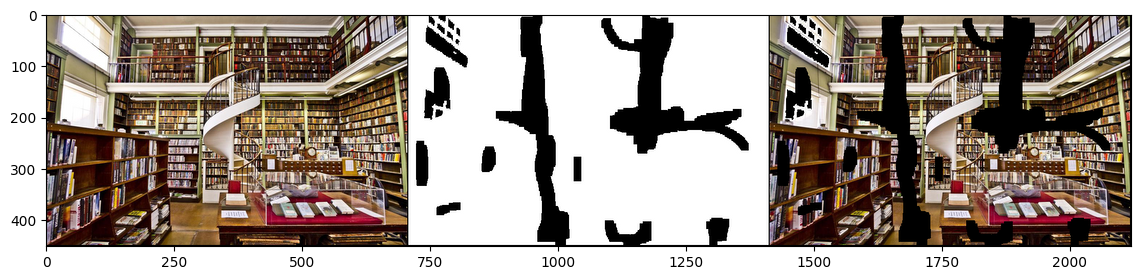

In [9]:
# Vase 
vase_path  = 'images/vase.png'
vase_mask = 'images/vase_mask.png'

# Library
library_path  = 'images/library.png'
library_mask = 'images/library_mask.png'

# Kate
kate_path  = 'images/kate.png'
kate_mask = 'images/kate_mask.png'

# One of skip_depth4 | skip_depth2 | UNET | ResNet
NET_TYPE = 'skip_depth6' 

# Setup
## One of reflection | zero
pad = 'reflection'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

# Load mask
img_pil, img_np = get_image(library_path, imsize)
img_mask_pil, img_mask_np = get_image(library_mask, imsize)

# Center crop
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

# Visualize
## Running on NVIDIA CUDA
##img_mask_var = np_to_torch(img_mask_np).type(dtype)

## Running on CPU
img_mask_var = np_to_torch(img_mask_np).type(torch.FloatTensor)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

In [13]:
# Library as the main attraction is shown first
INPUT = 'noise'
input_depth = 1
num_iter = 3001
show_every = 50
figsize = 8
reg_noise_std = 0.00
param_noise = True

if 'skip' in NET_TYPE:
    depth = int(NET_TYPE[-1])
    net = skip(input_depth, img_np.shape[0], 
                num_channels_down=[16, 32, 64, 128, 128, 128][:depth],
                num_channels_up=[16, 32, 64, 128, 128, 128][:depth],
                num_channels_skip=[0, 0, 0, 0, 0, 0][:depth],  
                filter_size_up=3, filter_size_down=5, filter_skip_size=1,
                upsample_mode='nearest',  # downsample_mode='avg',
                need1x1_up=False,
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').to(device)
    LR = 0.01 
    
elif NET_TYPE == 'UNET':
    net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                feature_scale=8, more_layers=1, 
                concat_x=False, upsample_mode='deconv', 
                pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True).to(device)
    
    LR = 0.001
    param_noise = False
    
elif NET_TYPE == 'ResNet':
    net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU').to(device)
    
    LR = 0.001
    param_noise = False
    
else:
    assert False

net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).to(device)

In [14]:
# Count number of parameters for this net
s = sum(np.prod(list(p.size())) for p in net.parameters())
print('Number of params: %d' % s)

# Function of loss (MSE)
mse = torch.nn.MSELoss()

# Convert images to tensores
img_var = np_to_torch(img_np).to(device)
mask_var = np_to_torch(img_mask_np).to(device)

Number of params: 2996467
